In [1]:
# Jupyter 환경에서 src 폴더의 모듈을 가져오기 위해 경로를 추가합니다.
import sys
# 경로 추가에 필요한 os 모듈을 가져옵니다.
import os

# 현재 노트북 파일의 상위 폴더(FALL-DETECTION)의 경로를 sys.path에 추가합니다.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# 이미지 및 비디오 처리를 위해 cv2(OpenCV)를 가져옵니다.
import cv2
# 시간 관련 기능을 위해 time 모듈을 가져옵니다.
import time
# numpy를 가져와서 수치 연산에 사용합니다.
import numpy as np

# src 폴더의 핵심 클래스들을 가져옵니다.
from src.detector import YoloDetector
from src.pose_estimator import PoseEstimator
from src.fall_logic import FallDetectorLogic


# 1. 초기화 (Initialization)
# ---

# YOLO, MediaPipe, 낙상 로직 클래스의 인스턴스를 생성합니다.
yolo_detector = YoloDetector()
pose_estimator = PoseEstimator()
fall_logic = FallDetectorLogic()

# 비디오 파일 경로 설정. (FALL-DETECTION/data/videos/fall.mp4)
video_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'data', 'videos', '03.mp4')

# OpenCV를 사용하여 비디오 파일을 엽니다.
cap = cv2.VideoCapture(video_path)

# 비디오 파일이 성공적으로 열렸는지 확인합니다.
if not cap.isOpened():
    print(f"Error: Could not open video file at {video_path}")
    # 노트북 실행을 중단합니다.
    raise FileNotFoundError("Video file not found or could not be opened.")

# 프레임 수를 제한하여 디버깅 속도를 높입니다. (예: 50 프레임만 처리)
# FRAME_LIMIT = 240
frame_count = 0

# 낙상 지표 기록을 위한 리스트를 초기화합니다.
# 시각화 셀에서 그래프를 그리는 데 사용됩니다.
status_history = []


# 2. 메인 처리 루프 (Main Processing Loop)
# ---

# 비디오가 열려 있고 프레임 제한을 넘지 않은 동안 반복합니다.
while cap.isOpened():
    # 비디오에서 다음 프레임을 읽습니다.
    ret, frame = cap.read()
    
    # 프레임을 제대로 읽지 못했다면 루프를 종료합니다.
    if not ret:
        break

    # 현재 시간을 기록합니다.
    current_time = time.time()
    
    # 1. YOLO를 사용하여 사람을 감지하고 바운딩 박스를 얻습니다.
    detections = yolo_detector.detect_person(frame)

    # 감지된 각 사람에 대해 반복합니다.
    for person_data in detections:
        bbox = person_data['bbox']
        # 디버깅 목적으로 임시 track_id 1을 사용합니다.
        track_id = 1 

        # 2. MediaPipe를 사용하여 뼈대 랜드마크를 추정하고 프레임에 그립니다.
        pose_landmarks = pose_estimator.estimate_pose(frame)
        
        # 3. 낙상 로직을 실행하여 상태를 판단합니다.
        person_status = fall_logic.process_detection(track_id, bbox, current_time)

        # 상태 기록 (디버깅 그래프 생성을 위해)
        status_history.append({'frame': frame_count, 'status': person_status})

        # 4. 시각화 및 결과 출력
        x1, y1, x2, y2 = bbox
        color = (0, 255, 0)
        if 'Fall' in person_status or 'Lying' in person_status:
            color = (0, 0, 255) # 낙상/누움 상태는 빨간색

        # 바운딩 박스를 프레임에 그립니다.
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        # 상태 텍스트를 프레임에 표시합니다.
        cv2.putText(frame, person_status, (x1, y1 - 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
    # 처리된 프레임을 시각적으로 확인합니다.
    # if frame_count % 10 == 0:
    print(f"Processing frame: {frame_count} - Status: {person_status}")

    frame_count += 1

# 3. 종료 (Finalization)
# ---

# 비디오 캡처 자원을 해제합니다.
cap.release()
print("Processing complete.")


0: 384x640 1 person, 1 traffic light, 244.6ms
Speed: 11.9ms preprocess, 244.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Processing frame: 0 - Status: Standing

0: 384x640 2 persons, 39.7ms
Speed: 1.2ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame: 1 - Status: Standing

0: 384x640 1 person, 1 traffic light, 37.8ms
Speed: 0.9ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame: 2 - Status: Standing

0: 384x640 2 persons, 41.2ms
Speed: 1.1ms preprocess, 41.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame: 3 - Status: Standing

0: 384x640 2 persons, 1 traffic light, 39.7ms
Speed: 1.0ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame: 4 - Status: Standing

0: 384x640 2 persons, 49.3ms
Speed: 1.3ms preprocess, 49.3ms inference, 1.1ms postprocess per image at shape (1, 3, 3

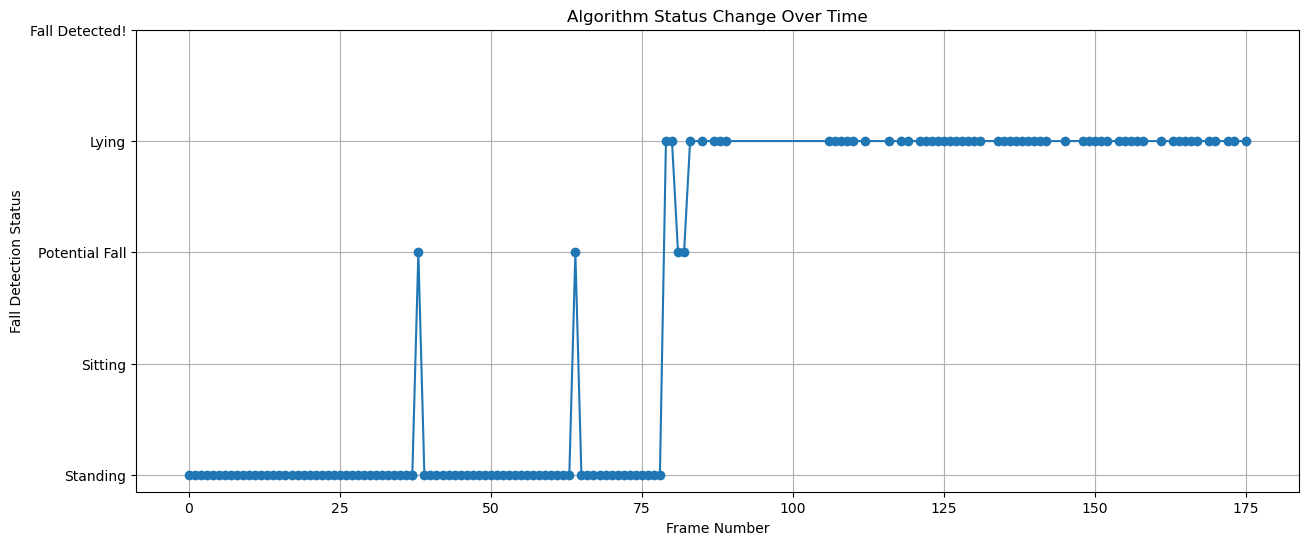


--- Final Status Log (First 10 entries) ---
   frame    status
0      0  Standing
1      1  Standing
2      2  Standing
3      3  Standing
4      4  Standing
5      5  Standing
6      6  Standing
7      7  Standing
8      8  Standing
9      9  Standing


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 기록된 상태 히스토리를 DataFrame으로 변환합니다.
df = pd.DataFrame(status_history)

# 시간 경과에 따른 상태 변화를 시각화합니다.
plt.figure(figsize=(15, 6))
# 상태를 시각화하기 위해 각 상태에 숫자 값을 부여합니다.
status_map = {'Standing': 0, 'Sitting': 1, 'Potential Fall': 2, 'Lying': 3, 'Fall Detected!': 4}
df['status_code'] = df['status'].map(status_map)

# 상태 코드 변화를 프레임 번호에 따라 그래프로 표시합니다.
plt.plot(df['frame'], df['status_code'], marker='o', linestyle='-')
plt.yticks(list(status_map.values()), list(status_map.keys()))
plt.xlabel("Frame Number")
plt.ylabel("Fall Detection Status")
plt.title("Algorithm Status Change Over Time")
plt.grid(True)
plt.show()

# 최종적으로 기록된 상태 변화를 출력합니다.
print("\n--- Final Status Log (First 10 entries) ---")
print(df[['frame', 'status']].head(10))